<CENTER>
    <a href="http://opendata.atlas.cern/release/2020/documentation/notebooks/intro.html" class="icons"><img src="../images/ATLASOD.gif" style="width:40%"></a>
</CENTER>

# <CENTER><h1> Searching the Graviton </h1></CENTER>

This notebook provides the analysis of the Graviton decaying into two Z bosons. This analysis implements two main cuts, which are applied in the lepton type and lepton charge of the four leptons in the final state. At the end of this analysis, you will be able to get a plot with the mass of the four lepton system, taking into account the contribution of MC samples (a stacked plot). Here you can find many tools to perform the desired selection of events, how to declare histograms, variables, read ROOT files and so on. 

Our analysis requires that the final state contains 4 leptons, which can be put in pairs with opposite charges and same flavours. That means we would have two pairs of electrons, muons or one pair of electrons and one pair of muons such as the Feynman Diagrams show below: 

$G \rightarrow ZZ \rightarrow e^{+} e^{-} e^{+} e^{-}$ | $G \rightarrow ZZ \rightarrow \mu^{+} \mu^{-} \mu^{+} \mu^{-}$ |$G \rightarrow ZZ \rightarrow e^{+} e^{-} \mu^{+} \mu^{-}$
:-------------------------:|:-------------------------:|:-------------------------:
![Graviton 4e](../images/graviton4e.png)  |  ![Graviton 4 mu](../images/graviton4mu.png) |  ![Graviton eemumu](../images/gravitoneemumu.png)

<a id='contents'></a>

# Contents: 

[Useful libraries in c++](#useful_libraries) <br />
[Lumi, fraction, file path](#parameters) <br />
[Maps declaration](#maps_declaration) <br />
[Histograms declaration](#histograms_declaration) <br />
[Declaration of variables used in the analysis](#declaration_of_variables) <br />
[Useful functions to use in our analysis](#useful_functions) <br />
[Changing a cut](#changing_cut) <br />
  [Lepton charge cut](#charge_cut) <br />
  [Lepton type cut](#type_cut) <br />
[Applying a cut](#applying_cut) <br />
[Samples](#samples) <br />
[Running the analysis!](#running) <br />
[Plotting our final results!](#plotting) <br />

<a id='useful_libraries'></a>

## Useful libraries in c++

The first step is to load some basic libraries of c++:

In [1]:
#include <TChain.h>
#include <vector>
#include <TFile.h>
#include <iostream>
#include <string>
#include <stdio.h>
#include <chrono>

[Back to contents](#contents)

<a id='parameters'></a>

## Lumi, fraction, file path

The data we want to use to perform our analysis can be found in the [folder 4 lep](https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/4lep/). Here you will see the data and MC samples that correspond to 4 leptons in the final state. We also define a variable named **lumi**, which represents the luminosity and it is equal to 10 $fb^{-1}$. If we want to run the analysis over a fraction of the whole data and MC samples, we can define another variable named **fraction**, which will be defined equal to 1.0 as default. However, you can change this fraction value and see how this can affect the final result shown in the final plot:

In [2]:
float lumi = 10.;
float fraction = 1.0;
TString path = "https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/4lep/";   

[Back to contents](#contents)

<a id='maps_declaration'></a>

## Maps declaration

Next, we define some maps which will be representing the main groups of background in our analysis for MC samples. These maps will save the name of each ROOT file used for the analysis and their corresponding scale given by a weight factor. This weight factor is given by considering the efficiency of calorimeters, the sum of all weights for each sample and the cross section for each sample. All of these parameters can be found in the sample.txt file in the same folder of this notebook.

In [3]:
std::map<TString, float> zttb;
std::map<TString, float> vttb;
std::map<TString, float> dzz;
std::map<TString, float> gr;

Once we have defined the maps, we can start by defining the histograms we are going to fill with the mass of the four lepton system for data and MC samples. Basically, we have defined four main groups of MC samples, which are:
* $Z-t\bar{t}$: This background contains the Z going to ee, mumu and the ttbar decaying in the leptonic channel MC samples.
* $t\bar{t}-V$: This background contains the ttbar decaying into W bosons, ee and mumu MC samples.  
* $ZZ$: This background contains the diboson ZZ decaying into 4 leptons.
* $Graviton-signal$: This contains the signal we want to search.

[Back to contents](#contents)

<a id='histograms_declaration'></a>

## Histograms declaration

Now that we have identified the main sources of backgrounds in our process, we should declare some histograms that will contain the information of a certain variable for each event. In this case, we want to fill our histograms with the invariant mass of the four leptons system, so we are going to declare five histograms (one for our data and four for the main groups of MC samples) such as follow:

In [4]:
//data samples
TH1F *data_hist_mllll = new TH1F("data_hist_m4l", "Normalized Mass of four lepton system; m_{4l} [GeV];Events", 30, 130, 1230);

//z_ttbar
TH1F *z_ttbar_hist_mllll = new TH1F("z_ttbar_hist_m4l", "Normalized Mass of four lepton system; m_{4l} [GeV];Events ", 30, 130, 1230);

//ttbar_v
TH1F *ttbar_v_hist_mllll = new TH1F("ttbar_v_hist_m4l", "Normalized Mass of four lepton system; m_{4l} [GeV];Events", 30, 130, 1230);

//zz
TH1F *zz_hist_mllll = new TH1F("zz_hist_m4l", "Normalized Mass of four lepton system; m_{4l} [GeV];Events", 30, 130, 1230);

//graviton
TH1F *graviton_hist_mllll = new TH1F("graviton_hist_m4l", "Normalized Mass of four lepton system; m_{4l} [GeV];Events", 30, 130, 1230);

[Back to contents](#contents)

<a id='declaration_of_variables'></a>

## Declaration of variables used in the analysis

In order to save the information stored in the ROOT files, we define all variables we are going to use in the next code line: 

In [5]:
Float_t         mcWeight;
Float_t         scaleFactor_PILEUP;
Float_t         scaleFactor_ELE;
Float_t         scaleFactor_MUON;
Float_t         scaleFactor_LepTRIGGER;
Bool_t          trigE;
Bool_t          trigM;
UInt_t          lep_n;
vector<float>   *lep_pt;
vector<float>   *lep_eta;
vector<float>   *lep_phi;
vector<float>   *lep_E;
vector<float>   *lep_z0;
vector<int>     *lep_charge;
vector<unsigned int> *lep_type;
vector<bool>    *lep_isTightID;
vector<float>   *lep_ptcone30;
vector<float>   *lep_etcone20;
vector<float>   *lep_trackd0pvunbiased;
vector<float>   *lep_tracksigd0pvunbiased;
Float_t         met_et;
Float_t         met_phi;
UInt_t          jet_n;
vector<float>   *jet_pt;
vector<float>   *jet_eta;
vector<float>   *jet_phi;
vector<float>   *jet_E;
vector<float>   *jet_jvt;
vector<float>   *jet_MV2c10;

[Back to contents](#contents)

<a id='useful_functions'></a>

## Useful functions to use in our analysis

For all samples we use, we have to rewrite the variables defined previously, so we create a function that receives the name of the chain (that is, the name of the MC samples group or the data depending on which sample we are analyzing), the name of the sample and their DSID (a number that identifies each MC sample). This function returns a tree with the information of the sample and rewrites the variables we are going to use at the same time. It also reads the information of samples by editing the tuple path, so it is important to separate data and MC samples because they are stored in different folders into the [folder 4 lep](https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/4lep/). It is only needed to consider an extra variable of type TString named prefix in order to divide them:

In [6]:
TTree* set_branch_address(TString name_chain, TString name_sample, int DSID_id)
{
    ostringstream DSID; //Needed to use the DSID number of int variable to a string variable
    DSID << DSID_id;
    TString sDSID = DSID.str();
    
    TString prefix, fileString;
    
    if(name_chain=="data"){
        prefix = "Data/";
        
    }
    else{
        prefix = "MC/mc_"+sDSID+".";
    }
    
    fileString = path+prefix+name_sample+".4lep.root"; //The final tuple path in which we can find the ROOT file
    
    TFile *file = TFile::Open(fileString);
    TTree *tree = (TTree*) file->Get("mini");
    //Save the information of the tree "mini" to the variables defined above.
    tree->SetBranchAddress("trigE", &trigE); 
    tree->SetBranchAddress("trigM", &trigM); 
    tree->SetBranchAddress("lep_isTightID", &lep_isTightID); 
    tree->SetBranchAddress("lep_pt", &lep_pt); 
    tree->SetBranchAddress("lep_eta", &lep_eta); 
    tree->SetBranchAddress("lep_phi", &lep_phi); 
    tree->SetBranchAddress("lep_E", &lep_E); 
    tree->SetBranchAddress("lep_n", &lep_n); 
    tree->SetBranchAddress("lep_type", &lep_type); 
    tree->SetBranchAddress("lep_ptcone30", &lep_ptcone30); 
    tree->SetBranchAddress("lep_etcone20", &lep_etcone20);
    tree->SetBranchAddress("lep_trackd0pvunbiased", &lep_trackd0pvunbiased); 
    tree->SetBranchAddress("lep_tracksigd0pvunbiased", &lep_tracksigd0pvunbiased); 
    tree->SetBranchAddress("lep_z0", &lep_z0); 
    tree->SetBranchAddress("lep_type", &lep_type); 
    tree->SetBranchAddress("lep_charge", &lep_charge); 
    tree->SetBranchAddress("met_et", &met_et); 
    tree->SetBranchAddress("jet_n", &jet_n);
    tree->SetBranchAddress("jet_pt", &jet_pt); 
    tree->SetBranchAddress("jet_eta", &jet_eta);
    tree->SetBranchAddress("jet_jvt", &jet_jvt); 
    tree->SetBranchAddress("jet_MV2c10", &jet_MV2c10); 
    
    tree->SetBranchAddress("mcWeight", &mcWeight); 
    tree->SetBranchAddress("scaleFactor_PILEUP", &scaleFactor_PILEUP); 
    tree->SetBranchAddress("scaleFactor_ELE", &scaleFactor_ELE); 
    tree->SetBranchAddress("scaleFactor_MUON", &scaleFactor_MUON); 
    tree->SetBranchAddress("scaleFactor_LepTRIGGER", &scaleFactor_LepTRIGGER); 
    
    return tree; 
}

The **scaling histogram** function will allow us to scale the histograms to compare data and the contribution of MC samples. This function uses the weight of scaling due to efficiency of the calorimeters, the sum of weights for MC and the cross section samples to scale the contributions of all samples. Of course, the data are not needed to be scaled, this only apply for MC samples:

In [7]:
void scaling_histogram(TString name_chain, TString name_sample, int n_sample, TH1F *hist_sample)
{
    if(name_chain=="data"){
        if(n_sample==0){ data_hist_mllll = (TH1F*) hist_sample->Clone();}
        if(n_sample!=0){ data_hist_mllll->Add(hist_sample);}
    }
    
    if(name_chain == "z_ttbar"){
        for(std::map<TString, float>::iterator it = zttb.begin(); it != zttb.end(); ++it){
            if(name_sample==it->first){
                hist_sample->Scale(it->second); //Used to scale the histogram with the factor weight explained above.
                if(n_sample==0){ z_ttbar_hist_mllll = (TH1F*) hist_sample->Clone();}
                if(n_sample!=0){ z_ttbar_hist_mllll->Add(hist_sample);}
            }
        }
    }
    if(name_chain == "ttbar_v"){
        for(std::map<TString, float>::iterator it = vttb.begin(); it != vttb.end(); ++it){
            if(name_sample==it->first){
                hist_sample->Scale(it->second); //Used to scale the histogram with the factor weight explained above.
                if(n_sample==0){ ttbar_v_hist_mllll = (TH1F*) hist_sample->Clone();}
                if(n_sample!=0){ ttbar_v_hist_mllll->Add(hist_sample);}
            }
        }
    }   
    if(name_chain == "zz"){
        for(std::map<TString, float>::iterator it = dzz.begin(); it != dzz.end(); ++it){
            if(name_sample==it->first){
                hist_sample->Scale(it->second); //Used to scale the histogram with the factor weight explained above.
                if(n_sample==0){ zz_hist_mllll = (TH1F*) hist_sample->Clone();}
                if(n_sample!=0){ zz_hist_mllll->Add(hist_sample);}
            }
        }
    } 
    if(name_chain == "graviton"){
        for(std::map<TString, float>::iterator it = gr.begin(); it != gr.end(); ++it){
            if(name_sample==it->first){
                hist_sample->Scale(it->second); //Used to scale the histogram with the factor weight explained above.
                if(n_sample==0){ graviton_hist_mllll = (TH1F*) hist_sample->Clone();}
                if(n_sample!=0){ graviton_hist_mllll->Add(hist_sample);}
            }
        }
    }     
}

Now, we define a function that computes the factor weight due to the information in the **samples.txt** file. Although this process was done manually, you could edit it in order to read information for the sample.txt automatically by using the library fstream. We didn't use it in order to save time for the analysis. If you need to add samples, you will have to look for their information in the **samples.txt** file. 

In [8]:
void get_xsec_weight()
{
    // sample - xsec - red_eff - sumw - nevt; look for the sample.txt if you add a sample to the analysis
    float xsec=0, red_eff=0, sumw=0; 
        
    //z_ttbar
    //Zee		1950.5295		1		150277594200		79045597
    xsec=1950.5295, red_eff=1.0, sumw=150277594200;
    zttb["Zee"] = lumi*1000*xsec/(red_eff*sumw);
    
    //Zmumu		1950.6321		1		147334691090		77497800
    xsec=1950.6321, red_eff=1.0, sumw=147334691090;
    zttb["Zmumu"] = lumi*1000*xsec/(red_eff*sumw);

    //ttbar_lep		452.693559		1		49386600		49386600
    xsec=452.693559, red_eff=1.0, sumw=49386600;
    zttb["ttbar_lep"] = lumi*1000*xsec/(red_eff*sumw);
    
    //--------------------------------------------------------------------------------------
    
    //ttbar_v
    
    //ttW		0.60084912		1		4075279.75386		None
    xsec=0.60084912, red_eff=1.0, sumw=4075279.75386;
    vttb["ttW"] = lumi*1000*xsec/(red_eff*sumw);
    
    //ttee		0.0412888		1		51968.9384584		None
    xsec=0.0412888, red_eff=1.0, sumw=51968.9384584;
    vttb["ttee"] = lumi*1000*xsec/(red_eff*sumw);
    
    //ttmumu		0.04129216		1		52007.5311319		None
    xsec=0.04129216, red_eff=1.0, sumw=52007.5311319;
    vttb["ttmumu"] = lumi*1000*xsec/(red_eff*sumw);
    
    //-------------------------------------------------------------------------------------
    
    //zz
    
    //llll		1.2578		1		7538705.8077		17825300
    xsec=1.2578, red_eff=1.0, sumw=7538705.8077;
    dzz["llll"] = lumi*1000*xsec/(red_eff*sumw);
    
    //-------------------------------------------------------------------------------------
    
    //graviton
    
    //RS_G_ZZ_llll_c10_m0500		0.02373		1		27000		27000
    xsec=0.02373, red_eff=1.0, sumw=27000;
    gr["RS_G_ZZ_llll_c10_m0500"] = lumi*1000*xsec/(red_eff*sumw);
}

The function that computes the mass of the four lepton system is defined below. It needs the pT, $\eta$, $\phi$ and the energy of each lepton in order to get the invariant mass.

In [9]:
float calc_mllll(vector<float> lep_pt, vector<float> lep_eta, vector<float> lep_phi, vector<float>lep_E)
{
    float px_0 = lep_pt[0]*TMath::Cos(lep_phi[0]); // x-component of lep[0] momentum
    float py_0 = lep_pt[0]*TMath::Sin(lep_phi[0]); // y-component of lep[0] momentum
    float pz_0 = lep_pt[0]*TMath::SinH(lep_eta[0]); // z-component of lep[0] momentum
    float px_1 = lep_pt[1]*TMath::Cos(lep_phi[1]); // x-component of lep[1] momentum
    float py_1 = lep_pt[1]*TMath::Sin(lep_phi[1]); // y-component of lep[1] momentum
    float pz_1 = lep_pt[1]*TMath::SinH(lep_eta[1]); // z-component of lep[1] momentum
    float px_2 = lep_pt[2]*TMath::Cos(lep_phi[2]); // x-component of lep[2] momentum
    float py_2 = lep_pt[2]*TMath::Sin(lep_phi[2]); // y-component of lep[2] momentum
    float pz_2 = lep_pt[2]*TMath::SinH(lep_eta[2]); // z-component of lep[3] momentum
    float px_3 = lep_pt[3]*TMath::Cos(lep_phi[3]); // x-component of lep[3] momentum
    float py_3 = lep_pt[3]*TMath::Sin(lep_phi[3]); // y-component of lep[3] momentum
    float pz_3 = lep_pt[3]*TMath::SinH(lep_eta[3]); // z-component of lep[3] momentum
    float sumpx = px_0 + px_1 + px_2 + px_3; // x-component of 4-lepton momentum
    float sumpy = py_0 + py_1 + py_2 + py_3; // y-component of 4-lepton momentum
    float sumpz = pz_0 + pz_1 + pz_2 + pz_3; // z-component of 4-lepton momentum
    float sumE = lep_E[0] + lep_E[1] + lep_E[2] + lep_E[3]; // energy of 4-lepton system
    return TMath::Sqrt(sumE*sumE - sumpx*sumpx - sumpy*sumpy - sumpz*sumpz)/1000; // /1000 to go from MeV to GeV
}

[Back to contents](#contents)

<a id='changing_cut'></a>

## Changing a cut

Finally, we are going to apply the corresponding cuts of our analysis. For this reason, we are going to create an individual function for each cut. This would allow us to see the effect of applying each cut over the samples files separately if we wanted. Of course, we could create only one function that contains all cuts but it wouldn't allow us to see the effects of applying every cut separately, it would show us the final events after all cuts so the idea is to keep them separated.

<a id='charge_cut'></a>

### Lepton charge cut

This cut needs the lepton charge of each lepton, because we want to choose events that have a sum of the charge of the four lepton system equal to zero, ensuring the neutrality of the charge.

In [10]:
// cut on lepton charge
// paper: "selecting two pairs of isolated leptons, each of which is comprised of two leptons with the same flavour and opposite charge"
bool cut_lep_charge(vector<int> lep_charge)
{
    // throw away when sum of lepton charges is not equal to 0
    // first lepton is [0], 2nd lepton is [1] etc
    if( lep_charge[0]+lep_charge[1]+lep_charge[2]+lep_charge[3]!=0 ){return false;}
    return true;
}

[Back to contents](#contents)

<a id='type_cut'></a>

### Lepton type cut

This cut needs the lepton type of each lepton, because we want to choose events that have two pairs of electrons, two pairs of muons or one pair of electrons and one pair of muons in the final state. If the event doesn't fulfill this requirement, the event is dropped.

In [11]:
// cut on lepton type
// paper: "selecting two pairs of isolated leptons, each of which is comprised of two leptons with the same flavour and opposite charge"
bool cut_lep_type(vector<unsigned int> lep_type)
{
    // for an electron lep_type is 11
    // for a muon lep_type is 13
    // throw away when none of eeee, mumumumu, eemumu
    
    float sum_lep_type = lep_type[0] + lep_type[1] + lep_type[2] + lep_type[3];
    
    if(sum_lep_type!=44 && sum_lep_type!=48 && sum_lep_type!=52){ return false;}
    return true;
}

[Back to contents](#contents)

<a id='applying_cut'></a>

## Applying a cut

Now, we are going to create a function that performs the event selection for each sample. This function is named **analysis of samples** and requires the name chain (if the sample belongs to data or a main group of MC samples), the name sample, its DSID and a number of the sample among all samples in its chain of files. This function creates a local histogram, fills it with the computed mass and scales it with the weight factor, which is saved in the maps, and finally adds it to global histograms that will be stacked in the final plot. 

In [12]:
void analysis_of_samples(TString name_chain, TString name_sample, int DSID_id, int n_sample, TH1F *hist_sample)
{
    auto start = chrono::steady_clock::now(); //Start the clock
    
    int nbytes = 0;
    int pass = 0;
    TTree *tree = new TTree(); 
    tree = set_branch_address(name_chain, name_sample, DSID_id); //create a tree and set values for variables that will be used
    int nentries = 0;
    float weight = 0;

    if(name_chain == "data"){ weight = 1.0; } //The weight for data is always 1.
 
    nentries = (Int_t)tree->GetEntries();
    cout << "\t" << "Processing: "+name_sample << endl; //Print the name of the sample that is been processed

    for(int ii=0; ii<nentries*fraction; ii++)
    {
        nbytes = tree->GetEntry(ii);
        
        if(name_chain!="data"){
            //Total weight of the event
            float SF = scaleFactor_PILEUP*scaleFactor_ELE*scaleFactor_MUON*scaleFactor_LepTRIGGER;
            weight = mcWeight*SF;
        }
        
        //Applying lepton charge cut
        if(cut_lep_charge(*lep_charge)==false) continue;
    
        //Applying lepton type cut
        if(cut_lep_type(*lep_type)==false) continue;
    
        float mllll = 0;
        mllll = calc_mllll(*lep_pt, *lep_eta, *lep_phi, *lep_E); // Computes the invariant mass
        
        hist_sample->Fill(mllll, weight); //Fill the local histogram in this function 
        
        pass++;
    }
    
    // Scale the local histogram and add it to the global histograms
    scaling_histogram(name_chain, name_sample, n_sample, hist_sample); 
    
    // Reset the hist_sample histograms in order to use them to fill and scale them with the contribution of the others samples 
    // once the analysis_of_samples function is called again
    hist_sample->Reset();
    
    auto end = chrono::steady_clock::now();
    
    auto elapsed = chrono::duration_cast<chrono::milliseconds>(end - start).count();
    
    // Print the initial events and the number of events passing the analysis in the sample
    cout << "\t" << "nInt: " << nentries << "\t" << "nOut: " << pass << "\t" <<"in: " << elapsed << "ms" << endl;

}

[Back to contents](#contents)

<a id='samples'></a>

## Samples

Now, we are going to make a for loop for each group of samples (data and MC samples groups) and we will use the **analysis of samples** function to apply all cuts for all samples. In this function we can see all the samples that are going to be used in the analysis and to what group they belong. If you want to add more samples, consider modifying this function too. 

In [13]:
void graviton_analysis()
{   
    get_xsec_weight();
    vector<TString> data_samples = {"data_A", "data_B", "data_C", "data_D"};
    
    vector<TString> z_ttbar_samples = {"Zee", "Zmumu", "ttbar_lep"};
    vector<int> z_ttbar_DSID = {361106, 361107, 410000};
    
    vector<TString> ttbar_v_samples = {"ttW", "ttee", "ttmumu"};
    vector<int> ttbar_v_DSID = {410155, 410218, 410219};

    vector<TString> zz_samples = {"llll"};
    vector<int> zz_DSID = {363490};

    vector<TString> graviton_samples = {"RS_G_ZZ_llll_c10_m0500"};
    vector<int> graviton_DSID = {307434};
    
    TH1F *hist_sample = new TH1F("hist_sample_m4l", "Normalized Mass of four lepton system; m_{4l} [GeV];Events", 30, 130, 1230);

    for(int ii=0; ii<data_samples.size(); ii++){
        if(ii==0){ cout << "Processing data samples: " << endl; }
        analysis_of_samples("data", data_samples[ii], 0, ii, hist_sample); //Data samples don´t have DSID
    }
    
    for(int ii=0; ii<z_ttbar_samples.size(); ii++){
        if(ii==0){ cout << "Processing z_ttbar samples: " << endl; }
        analysis_of_samples("z_ttbar", z_ttbar_samples[ii], z_ttbar_DSID[ii], ii, hist_sample); 
    }

    for(int ii=0; ii<ttbar_v_samples.size(); ii++){
        if(ii==0){ cout << "Processing ttbar_v samples: " << endl; }
        analysis_of_samples("ttbar_v", ttbar_v_samples[ii], ttbar_v_DSID[ii], ii, hist_sample); 
    }
    
    for(int ii=0; ii<zz_samples.size(); ii++){
        if(ii==0){ cout << "Processing zz samples: " << endl; }
        analysis_of_samples("zz", zz_samples[ii], zz_DSID[ii], ii, hist_sample); 
    }
    
    for(int ii=0; ii<graviton_samples.size(); ii++){
        if(ii==0){ cout << "Processing graviton samples: " << endl; }
        analysis_of_samples("graviton", graviton_samples[ii], graviton_DSID[ii], ii, hist_sample); 
    }
    
}

[Back to contents](#contents)

<a id='running'></a>

## Running the analysis!

Run the next line if you want to start the analysis:

In [14]:
auto start = chrono::steady_clock::now(); //Start the clock
graviton_analysis();
auto end = chrono::steady_clock::now();
auto elapsed = chrono::duration_cast<chrono::seconds>(end - start).count();
cout << "Time taken: " << elapsed << "s" << endl;

Processing data samples: 
	Processing: data_A
	nInt: 39	nOut: 27	in: 4593ms
	Processing: data_B
	nInt: 156	nOut: 86	in: 116ms
	Processing: data_C
	nInt: 237	nOut: 146	in: 188ms
	Processing: data_D
	nInt: 400	nOut: 248	in: 107ms
Processing z_ttbar samples: 
	Processing: Zee
	nInt: 898	nOut: 243	in: 120ms
	Processing: Zmumu
	nInt: 684	nOut: 257	in: 118ms
	Processing: ttbar_lep
	nInt: 1031	nOut: 334	in: 159ms
Processing ttbar_v samples: 
	Processing: ttW
	nInt: 1373	nOut: 333	in: 151ms
	Processing: ttee
	nInt: 32092	nOut: 13883	in: 769ms
	Processing: ttmumu
	nInt: 26639	nOut: 10886	in: 665ms
Processing zz samples: 
	Processing: llll
	nInt: 554279	nOut: 523957	in: 9048ms
Processing graviton samples: 
	Processing: RS_G_ZZ_llll_c10_m0500
	nInt: 6496	nOut: 6002	in: 269ms
Time taken: 16s


[Back to contents](#contents)

<a id='plotting'></a>

## Plotting our final results!

Finally, we create a function that is going to plot the final results. This function shows us how to create legends, how to assign markers to data and MC groups, stack the MC contributions, put Latex text in the graph, print the canvas and save the final plot in a pdf file. Consider these tools if you want to beautify your plots in other analyses.

In [15]:
void plot_histogram_stacked()
{
    THStack* hstack = new THStack("hs1", "Mass of the four leptons system; m_{4l} [GeV] ;Events");
    
    TLegend *leg = new TLegend(0.6, 0.52, 0.85, 0.82); // Declares a legend to the function fit and his position in canvas
    
    data_hist_mllll->SetMarkerStyle(20);
    data_hist_mllll->SetMarkerColor(kBlack);
    data_hist_mllll->SetStats(0);
    
    z_ttbar_hist_mllll->SetFillColor(kMagenta-2);
    ttbar_v_hist_mllll->SetFillColor(kYellow);
    zz_hist_mllll->SetFillColor(kRed);
    graviton_hist_mllll->SetFillColor(kSpring-9);

    hstack->Add(z_ttbar_hist_mllll);
    hstack->Add(ttbar_v_hist_mllll);
    hstack->Add(zz_hist_mllll);
    hstack->Add(graviton_hist_mllll);
    hstack->SetMaximum(20*hstack->GetMaximum());
    hstack->SetMinimum(0.08);
    
    // statistical error histogram
    TH1F *h_err = (TH1F*) z_ttbar_hist_mllll->Clone();
    h_err->Add(ttbar_v_hist_mllll);
    h_err->Add(zz_hist_mllll);
    h_err->Add(graviton_hist_mllll);
  
    h_err->SetFillStyle(3004);
    h_err->SetFillColor(kBlack);
    h_err->SetLineColor(0);
    h_err->SetMarkerStyle(1);

    ///// Plotting
    TCanvas *can = new TCanvas("can","", 800, 600);

    can->SetLogy();

    hstack->Draw("hist");
    h_err->Draw("e2same");
    data_hist_mllll->Draw("epsame");

    leg->AddEntry(data_hist_mllll, "Data", "lep");
    
    leg->AddEntry(z_ttbar_hist_mllll,"Zt#bar{t}","f");
    leg->AddEntry(ttbar_v_hist_mllll,"Vt#bar{t}","f");
    leg->AddEntry(zz_hist_mllll,"ZZ","f");
    leg->AddEntry(graviton_hist_mllll,"Graviton","f");
    leg->AddEntry(h_err,"MC stat. uncertainty","f");
    
    leg->SetBorderSize();
    leg->Draw();
    
    TLatex l;
    l.SetNDC();
    l.SetTextFont(42);
    l.SetTextColor(kBlack);
    l.SetTextSize(0.035);  
    l.DrawLatex(0.15,0.8,Form("ATLAS Open Data work in progress"));

    TLatex o;
    o.SetNDC();
    o.SetTextFont(42);
    o.SetTextColor(kBlack);
    o.SetTextSize(0.03);
    double dely = 0.04; 
    o.DrawLatex(0.15,0.8-dely, Form("#sqrt{s} = 13 TeV, 10 fb^{-1}"));
    o.DrawLatex(0.15,0.76-dely, Form("G #rightarrow Z Z^{*} #rightarrow l^{+} l^{-} l^{+} l^{-}"));    
    
    can->Draw();
    can->Print("plots/Graviton_mllll_DataMC.pdf");
}

Run the next code line if you want to see the final plot of our analysis.

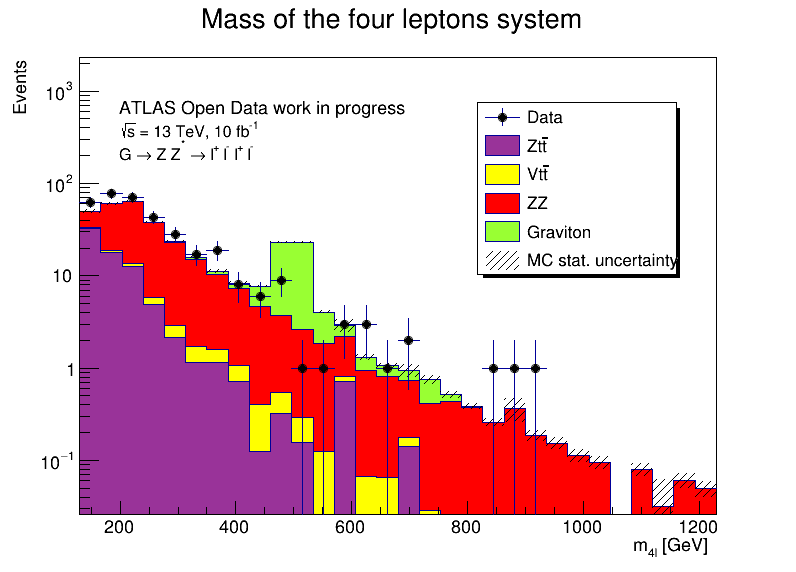

Info in <TCanvas::Print>: pdf file plots/Graviton_mllll_DataMC.pdf has been created


In [16]:
plot_histogram_stacked();

[Back to contents](#contents)